#### 状态方程参数估计

代码准备：

In [24]:
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 2))
sys.path.insert(0, BASE_DIR)

from setting import plt

In [25]:
def load_batch_test_data(label: str = "1") -> pd.DataFrame:
    """
    载入批次试验数据
    
    Params:
    -------
    label: 批次标签
    """
    
    cols=["unit_nb", "time_cycle"] + ["set_1", "set_2", "set_3"] + [f"s_{i}" for i in range(1, 22)]
    data = pd.read_csv(
        f"data/train_FD00{label}.txt", sep="\\s+", names=cols, header=None, index_col=False)
    return data


def load_unit_test_data(data: pd.DataFrame, unit_nb: int, x_col: str) -> np.ndarray:
    """
    载入单台设备上的试验数据
    
    Params:
    -------
    data: 批次试验数据
    unit_nb: 设备编号
    x_col: 所采集的信号名
    """
    
    arr = data[data["unit_nb"] == unit_nb][x_col].values  # type: ignore
    return arr

载入数据，以"s_4"作为该涡扇发动机系统的CI指标：

In [26]:
data = load_batch_test_data()
x = load_unit_test_data(data, 1, "s_4")

绘制该台发动机的CI曲线如下：

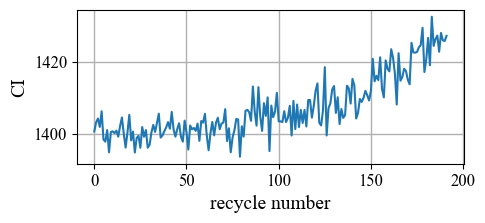

In [27]:
plt.figure(figsize=(5, 2))
plt.plot(x)
plt.xlabel("recycle number")
plt.ylabel("CI")
plt.grid(linewidth=1.0)
plt.show()

可以看出：
1. 该发动机的初始CI值在 $b$ = 1400左右；
2. 随着工作循环次数的增加，CI值逐步增大并接近失效。

接下来，我们需要通过以上CI数据，获得该发动机的CI退化状态方程，从而为后续从任意工作循环开始的CI退化曲线预测和剩余寿命估计作下铺垫。

设该发动机的CI退化状态方程如下：

$$
\left[\begin{array}{cc}
    x_{t+1} - b \\
    \Delta x_{t+1}
\end{array}\right] = 
\left[\begin{array}{cc}
    1, & 1 \\
    a, & 1 \\
\end{array}\right] \left[\begin{array}{cc}
    x_{t} - b \\
    \Delta x_{t}
\end{array}\right] + \left[\begin{array}{cc}
    \varepsilon^{\rm sys}_{1, t} \\
    \varepsilon^{\rm sys}_{2, t}
\end{array}\right]
$$

其中：
* $x_t$、$x_{t+1}$ 分别为时刻 $t$ 和 $t+1$ 上的CI状态值；$\Delta x_t$、$\Delta x_{t+1}$ 分别为对应时刻的CI状态增量；
* $b$ 为系统初始状态值；
* $a$ 为与系统当前状态（或时间）有关的系数；
* $\varepsilon^{\rm sys}_{1, t} \sim {\rm Norm}(\mu_{\rm sys, 1}, \sigma_{\rm sys, 1})$ 和 $\varepsilon^{\rm sys}_{2, t} \sim {\rm Norm}(\mu_{\rm sys, 2}, \sigma_{\rm sys, 2})$ 为对应的系统噪声。

此外，还需注意各状态值到观测值之间还存在观测噪声，即

$$
\hat x_{t+1} = x_{t + 1} + \varepsilon^{\rm obs}_{1, t + 1} \\
\hat x_{t} = x_{t} + \varepsilon^{\rm obs}_{1, t} \\

\Delta \hat x_{t+1} = \Delta x_{t + 1} + \varepsilon^{\rm obs}_{2, t + 1} \\
\Delta \hat x_{t} = \Delta x_{t} + \varepsilon^{\rm obs}_{2, t} \\

$$

其中，

$$
\varepsilon^{\rm obs}_{1, t}, \varepsilon^{\rm obs}_{1, t + 1} \sim {\rm Norm}(0, \sigma_{\rm obs, 1}) \\
\Delta\varepsilon^{\rm obs}_{1, t}, \Delta\varepsilon^{\rm obs}_{1, t + 1} \sim {\rm Norm}(0, \sigma_{\rm obs, 2}) \\

$$

综上，需基于实际观测数据 $\left\{\hat x\right\}$、$\left\{\Delta\hat x\right\}$，对退化状态方程涉及的参数 $a$、$b$、$\mu_{\rm sys, 1}$、$\sigma_{\rm sys, 1}$、$\mu_{\rm sys, 2}$、$\sigma_{\rm sys, 2}$、$\sigma_{\rm obs, 1}$、$\sigma_{\rm obs, 2}$ 进行估计。

基于PyMC的参数估计代码如下：

In [28]:
# 观测样本
x_t0 = x[: -2].copy()
dx_t0 = x[1: -1].copy() - x[: -2].copy()
dx_t1 = x[2:].copy() - x[1: -1].copy()

vars2eval = ["a", "b", "mu_sys_1", "sigma_sys_1", "mu_sys_2", "sigma_sys_2", "sigma_obs_1", "sigma_obs_2"]
    
with pm.Model() as model:
    a = pm.Normal("a", mu=1.0, sigma=0.1)
    b = pm.Normal("b", mu=1300.0, sigma=100.0)
    
    # 系统噪声参数
    mu_sys_1 = pm.Normal("mu_sys_1", mu=0.0, sigma=0.5)  # TODO：没用到
    sigma_sys_1 = pm.HalfNormal("sigma_sys_1", tau=5.0)  # TODO：没用到
    mu_sys_2 = pm.Normal("mu_sys_2", mu=0.0, sigma=0.1)
    sigma_sys_2 = pm.HalfNormal("sigma_sys_2", tau=1.0)
    
    # 观测噪声参数
    sigma_obs_1 = pm.HalfNormal("sigma_obs_1", tau=1.0)
    sigma_obs_2 = pm.HalfNormal("sigma_obs_2", tau=1.0)
    
    # 观测噪声样本
    eps_obs_1 = pm.Normal("eps_obs_1", mu=0, sigma=sigma_obs_1, shape=len(x_t0))
    eps_obs_2 = pm.Normal("eps_obs_2", mu=0, sigma=sigma_obs_2, shape=len(x_t0))
    
    # ---- 仅以dx_t1的观测结果估计参数 ----------------------------------------------------------------
    
    # dx_t1的状态值
    dx_t1_s = pm.Deterministic("dx_t1_s", a * (x_t0 - eps_obs_1 - b) + (dx_t0 - eps_obs_2))
    
    _ = pm.Normal(
        "dx_t1_obs",
        mu=dx_t1_s + mu_sys_2, 
        sigma=sigma_sys_2, 
        observed=dx_t1)
    
    step = pm.Metropolis()
    trace = pm.sample(10000, chains=1, tune=2000, step=step)
    
    az.summary(trace, var_names=vars2eval)
    az.plot_posterior(trace, var_names=vars2eval)

INFO:filelock:Lock 1371367160896 acquired on C:\Users\dreis\AppData\Local\PyTensor\compiledir_Windows-10-10.0.22621-SP0-Intel64_Family_6_Model_140_Stepping_1_GenuineIntel-3.8.8-64\.lock
INFO:filelock:Lock 1371367160896 released on C:\Users\dreis\AppData\Local\PyTensor\compiledir_Windows-10-10.0.22621-SP0-Intel64_Family_6_Model_140_Stepping_1_GenuineIntel-3.8.8-64\.lock
INFO:filelock:Lock 1371367162256 acquired on C:\Users\dreis\AppData\Local\PyTensor\compiledir_Windows-10-10.0.22621-SP0-Intel64_Family_6_Model_140_Stepping_1_GenuineIntel-3.8.8-64\.lock
INFO:filelock:Lock 1371367162256 released on C:\Users\dreis\AppData\Local\PyTensor\compiledir_Windows-10-10.0.22621-SP0-Intel64_Family_6_Model_140_Stepping_1_GenuineIntel-3.8.8-64\.lock
INFO:filelock:Lock 1371387404832 acquired on C:\Users\dreis\AppData\Local\PyTensor\compiledir_Windows-10-10.0.22621-SP0-Intel64_Family_6_Model_140_Stepping_1_GenuineIntel-3.8.8-64\.lock
INFO:filelock:Lock 1371387404832 released on C:\Users\dreis\AppData\Lo

d:\Anaconda\lib\site-packages\pymc\step_methods\metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 130 seconds.
INFO:pymc.sampling.mcmc:Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 130 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc.stats.convergence:Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


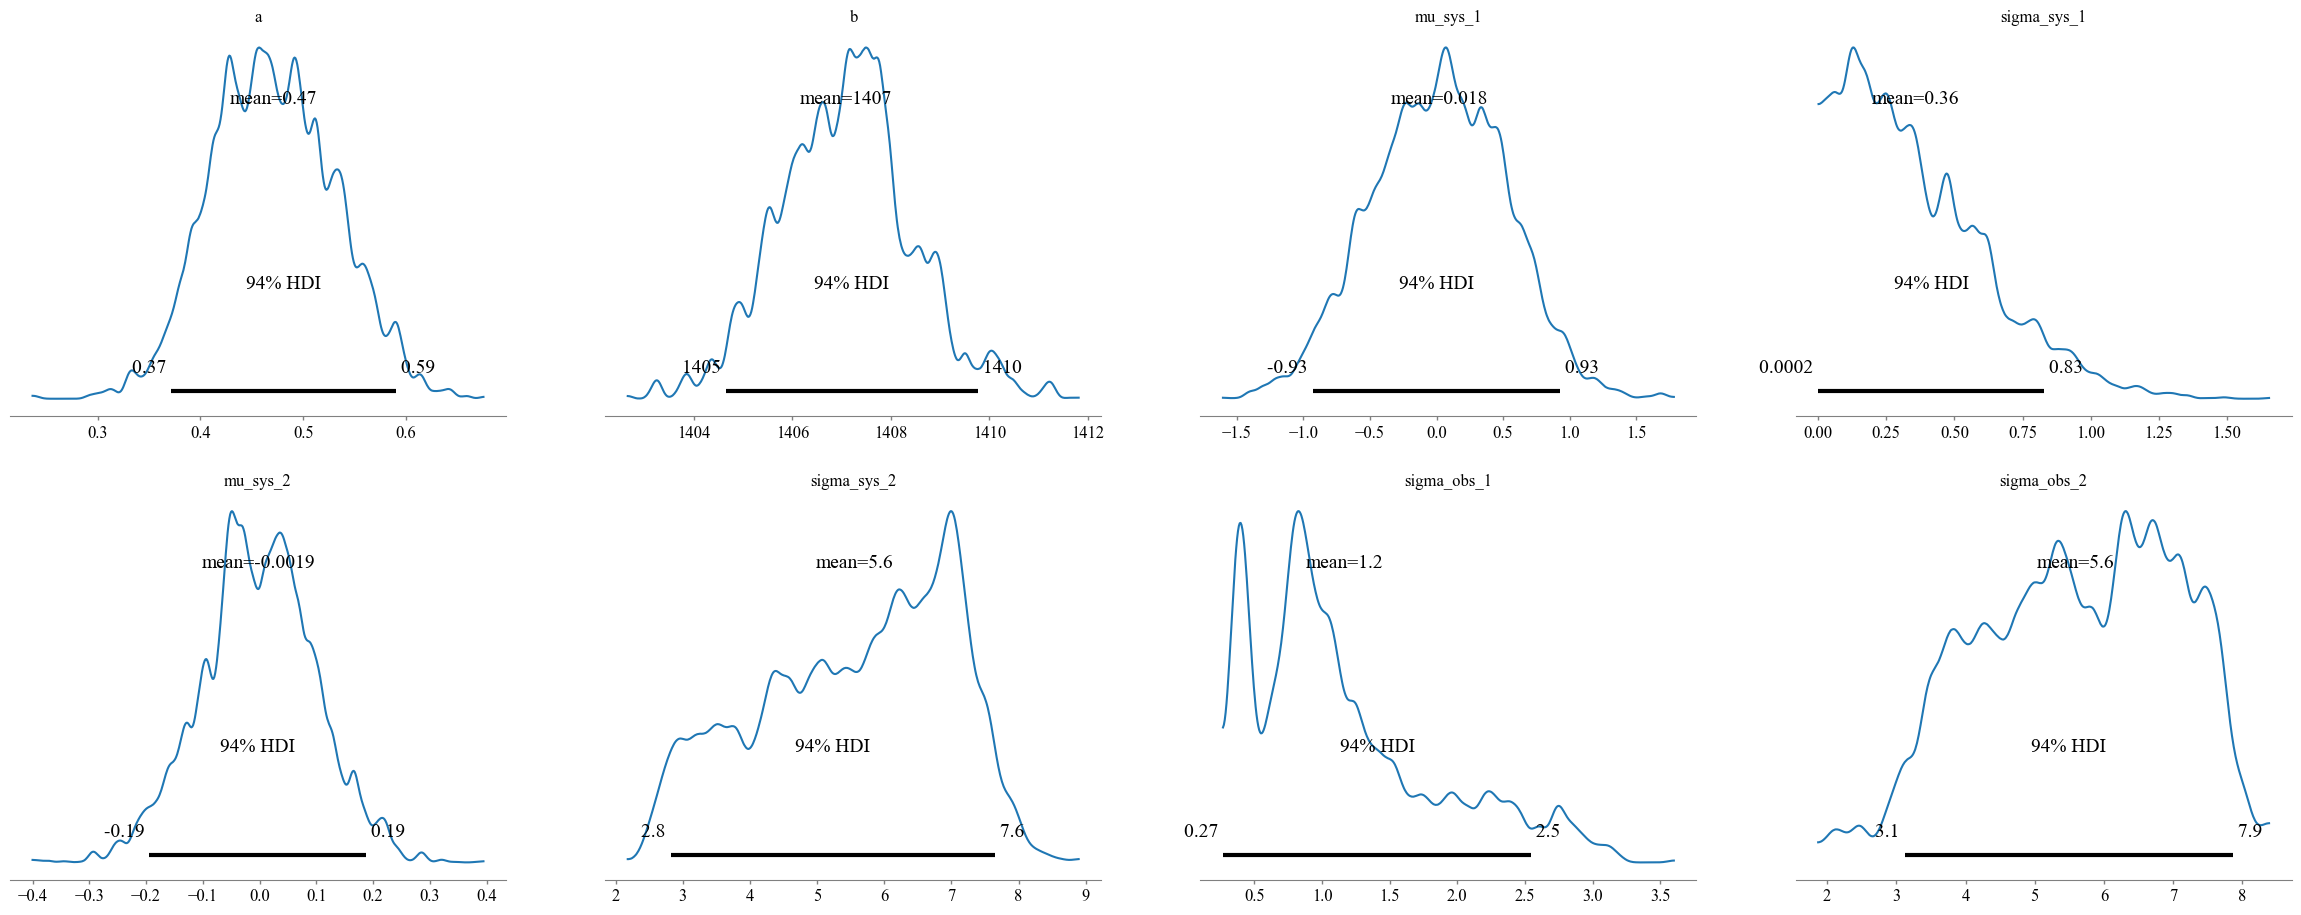

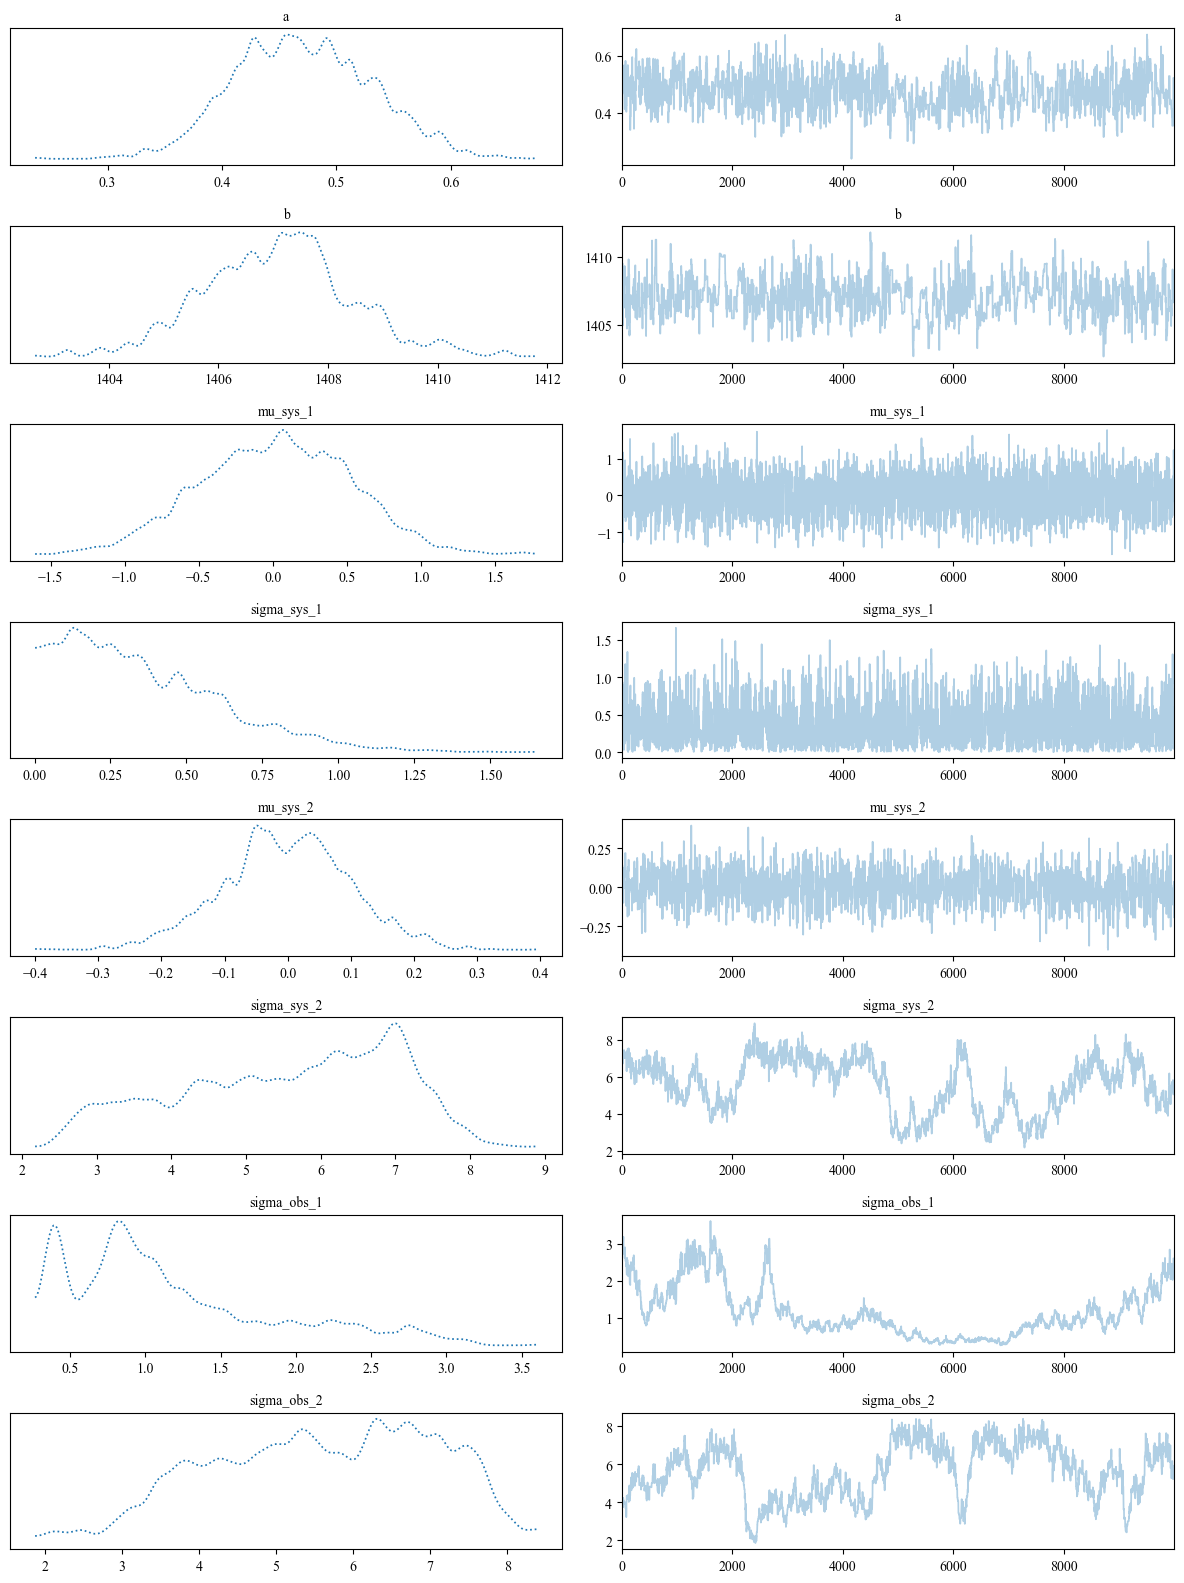

In [29]:
# 总结后验
az.plot_trace(
    trace,
    var_names=vars2eval,
    compact=True,
    combined=True)
plt.tight_layout()
plt.show()

综上可知：
* $a \approx 0.47$；
* $b \approx 1407$；
* $\varepsilon^{\rm obs}_{1, t}, \varepsilon^{\rm obs}_{1, t + 1} \sim {\rm Norm}(0, 1.2)$；
* $\Delta\varepsilon^{\rm obs}_{1, t}, \Delta\varepsilon^{\rm obs}_{1, t + 1} \sim {\rm Norm}(0, 5.6)$；
* $\varepsilon^{\rm sys}_{1, t} \sim {\rm Norm}(0.018, 0.36)$；
* $\varepsilon^{\rm sys}_{2, t} \sim {\rm Norm}(0.0, 5.6)$。
